<a href="https://colab.research.google.com/github/TharuWitharana/image-classification-using-dl/blob/main/TrainedFinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow
!pip install tensorflow-addons
!pip install vit-keras
!pip install typeguard
!pip install ml-dtypes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.0
    Uninstalling typeguard-4.4.0:
      Successfully uninstalled typeguard-4.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 4.2 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import random
import shutil
import warnings
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau , CSVLogger
from keras.utils import plot_model
tf.get_logger().setLevel('ERROR')


In [4]:
# Define the path to the directory containing your dataset
# This is the directory where your dataset is stored in Google Drive
directory_path = '/content/drive/MyDrive/SplittedNovelDatasetv3'

# List all files in the directory
# The os.listdir() function returns a list of all files and directories in the specified path
files = os.listdir(directory_path)

# Print the list of files
# This will display the names of all the files in the specified directory
print(files)

['train', 'test', 'validation']


In [5]:
# Set a random seed value for reproducibility
SEED = 42

# Seed the random number generator in NumPy
# Setting a seed ensures that the random numbers generated are the same every time the code is run,
# which is useful for reproducibility in experiments and debugging
np.random.seed(SEED)

In [6]:
# Insert the Dataset path here
# Define the path to the training dataset directory
train_path = '/content/drive/MyDrive/SplittedNovelDatasetv3/train'

# Define the path to the validation dataset directory
val_path = '/content/drive/MyDrive/SplittedNovelDatasetv3/validation'

# Define the path to the testing dataset directory
test_path = '/content/drive/MyDrive/SplittedNovelDatasetv3/test'


In [7]:
# Set the size of the images to be used in the model (e.g., 224x224 pixels)
IMAGE_SIZE = 224

# Set the number of samples to process before updating the model's weights
BATCH_SIZE = 32

# Set the number of epochs for training the model
EPOCHS = 100

# Set the learning rate for the optimizer (controls how much to change the model in response to the estimated error each time the model weights are updated)
LEARNING_RATE = 1e-4

# Set the width multiplier for the MobileNet architecture (scales the width of the network by this factor)
WIDTH_MULTIPLIER = 1


In [8]:
# Create an ImageDataGenerator instance for training data with various augmentations
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,                   # Normalize pixel values to [0, 1]
    rotation_range=360,               # Randomly rotate images by up to 360 degrees
    height_shift_range=0.1,           # Randomly shift images vertically by up to 10% of the height
    shear_range=0.1,                  # Apply random shearing transformations
    zoom_range=0.1,                   # Apply random zoom
    fill_mode='nearest',              # Fill in newly created pixels with the nearest pixel value
    brightness_range=[0.8, 1.4],     # Randomly change the brightness of images
    vertical_flip=True,               # Randomly flip images vertically
    horizontal_flip=True)             # Randomly flip images horizontally

# Create an ImageDataGenerator instance for validation data with only normalization
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)                   # Normalize pixel values to [0, 1]

# Create an ImageDataGenerator instance for test data with only normalization
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)                   # Normalize pixel values to [0, 1]

# Create a data generator for training with augmented images
train_generator = train_datagen.flow_from_directory(
    train_path,                       # Path to the training data
    target_size=(IMAGE_SIZE, IMAGE_SIZE),  # Resize images to the specified size
    batch_size=BATCH_SIZE,            # Number of images to return in each batch
    class_mode='categorical')         # Use categorical labels (one-hot encoded)

# Create a data generator for validation data with normalization only
validation_generator = val_datagen.flow_from_directory(
    val_path,                         # Path to the validation data
    target_size=(IMAGE_SIZE, IMAGE_SIZE),  # Resize images to the specified size
    batch_size=BATCH_SIZE,            # Number of images to return in each batch
    class_mode='categorical')         # Use categorical labels (one-hot encoded)

# Create a data generator for test data with normalization only, no shuffling
test_generator = test_datagen.flow_from_directory(
    test_path,                        # Path to the test data
    target_size=(IMAGE_SIZE, IMAGE_SIZE),  # Resize images to the specified size
    batch_size=BATCH_SIZE,            # Number of images to return in each batch
    class_mode='categorical',         # Use categorical labels (one-hot encoded)
    shuffle=False)                    # Do not shuffle the test data


Found 948 images belonging to 8 classes.
Found 203 images belonging to 8 classes.
Found 207 images belonging to 8 classes.


In [9]:
def num_of_classes(folder_dir, folder_name):
    """
    Print the number of classes in a specified directory.

    Parameters:
    folder_dir (str): The path to the directory containing subdirectories of classes.
    folder_name (str): The name of the folder for display purposes.
    """
    # List all subdirectory names (class names) in the specified directory
    classes = [class_name for class_name in os.listdir(folder_dir)]

    # Print the number of classes found in the directory with bold blue text
    print(colored(f'number of classes in {folder_name} folder : {len(classes)}', 'blue', attrs=['bold']))



In [10]:
# Print the number of classes in the training dataset
num_of_classes(train_path, 'train')

# Print the number of classes in the validation dataset
num_of_classes(val_path, 'validation')

# Print the number of classes in the test dataset
num_of_classes(test_path, 'test')


number of classes in train folder : 8
number of classes in validation folder : 8
number of classes in test folder : 8


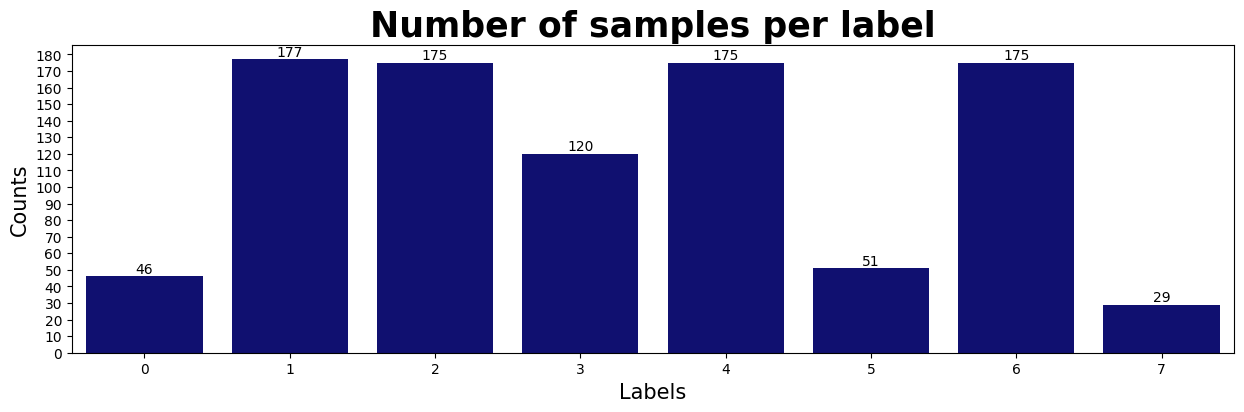

In [11]:
# Get the class names from the training data directory
classes = [class_name for class_name in os.listdir(train_path)]

# Count the number of samples in each class directory
count = [len(os.listdir(os.path.join(train_path, class_name))) for class_name in classes]

# Convert class names to integers if they are in string format and sort them
# This assumes class names can be converted to integers for sorting purposes
sorted_classes = sorted(classes, key=int)
sorted_count = [count[classes.index(class_name)] for class_name in sorted_classes]

# Plot the sorted class counts
plt.figure(figsize=(15, 4))  # Set the figure size for the plot

# Create a bar plot with seaborn
ax = sns.barplot(x=sorted_classes, y=sorted_count, color='navy')

# Adjust x-axis tick labels to be horizontal (no rotation)
plt.xticks(rotation=0)

# Add labels on top of the bars
for container in ax.containers:
    ax.bar_label(container)

# Set the plot title and axis labels
plt.title('Number of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)

# Set y-axis ticks with a step of 10
plt.yticks(np.arange(0, max(sorted_count) + 10, 10))

# Display the plot
plt.show()


In [12]:
# Function to create a DataFrame from images in a given folder
def create_df(folder_path):
    all_images = []  # Initialize an empty list to store image paths and labels

    # Iterate over each class directory
    for class_name in classes:
        class_path = os.path.join(folder_path, class_name)  # Path to the current class directory

        # List all files in the current class directory and create a list of tuples (file_path, label)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])

    # Create a DataFrame from the list of tuples with columns 'file_path' and 'label'
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df  # Return the DataFrame

# Create DataFrames for training, validation, and test datasets
train_df = create_df(train_path)
validation_df = create_df(val_path)
test_df = create_df(test_path)

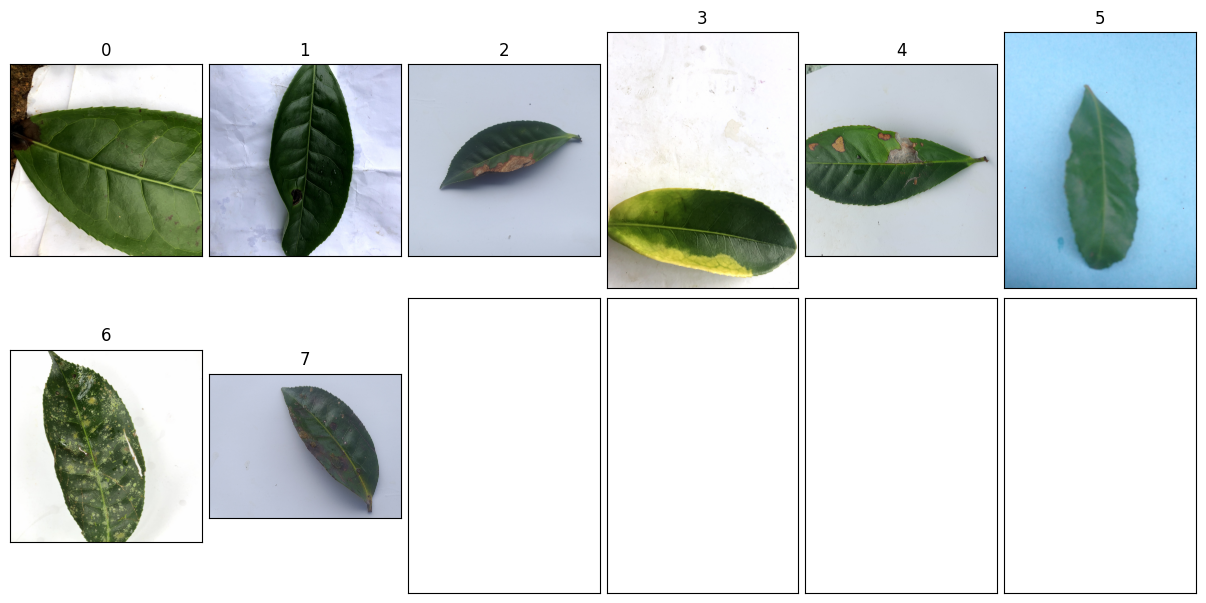

In [13]:
# Ensure that train_df is sorted by label
train_df_sorted = train_df.copy()  # Create a copy of the train DataFrame to avoid modifying the original
train_df_sorted['label'] = train_df_sorted['label'].astype(int)  # Convert labels to integers if they are in string format
train_df_sorted = train_df_sorted.sort_values(by='label').reset_index(drop=True)  # Sort by label and reset the index

# Create a DataFrame containing only one image per label
df_unique = train_df_sorted.drop_duplicates(subset=["label"]).reset_index(drop=True)

# Plot a selection of images from the dataset
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 6), subplot_kw={'xticks': [], 'yticks': []})
# Create a grid of subplots (2 rows x 6 columns) for displaying images

for i, ax in enumerate(axes.flat):
    if i < len(df_unique):  # Ensure the index is within the bounds of df_unique
        img = plt.imread(df_unique.file_path[i])  # Read the image from the file path
        ax.imshow(img)  # Display the image
        ax.set_title(df_unique.label[i], fontsize=12)  # Set the title of the subplot to the label of the image

plt.tight_layout(pad=0.5)  # Adjust the layout to prevent overlap
plt.show()  # Display the plot


In [14]:
# Import the MobileNet model from TensorFlow's Keras applications
mobile = tf.keras.applications.MobileNet()

# Explanation:
# This line initializes the MobileNet model with default parameters.
# MobileNet is a lightweight neural network designed for mobile and edge devices,
# providing a good trade-off between speed and accuracy for image classification tasks.
# By default, this model is initialized with pre-trained weights from ImageNet.


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
# Print the summary of the MobileNet model
mobile.summary()

# Explanation:
# This function call outputs a detailed summary of the MobileNet model architecture.
# It includes information about the layers, their output shapes, the number of parameters
# (both trainable and non-trainable), and the overall model structure.
# This summary helps in understanding the model's design and verifying the configuration.

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [15]:
# Load the pre-trained MobileNet model
mobile = MobileNet()

In [16]:
# Take the output from the fifth-to-last layer of MobileNet
x = mobile.layers[-5].output


# Reshape the output to be 1D tensor with 1024 elements
x = Reshape(target_shape=(1024,))(x)


# Add a dense layer with 8 units(number of classes) and softmax activation for classification
output = Dense(units=8, activation='softmax')(x)

In [17]:
# Create a new model with the same input as MobileNet but with the new output layer
model = Model(inputs=mobile.input, outputs=output)

# Freeze all layers except the last 22 layers
for layer in model.layers[:-22]:
    layer.trainable = False


In [18]:

# Define the directory where model progress and logs will be saved
save_dir = '/content/drive/MyDrive/fypmodel/MobilenetV1/new3'

# Create the main directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Define and create subdirectories for saving model weights and logs
weights_dir = os.path.join(save_dir, 'weights')
os.makedirs(weights_dir, exist_ok=True)  # Create directory for saving model weights

logs_dir = os.path.join(save_dir, 'logs')
os.makedirs(logs_dir, exist_ok=True)  # Create directory for saving logs


In [19]:
# Define the ModelCheckpoint callback to save model weights during training
model_checkpoint_callback = ModelCheckpoint(
    # Specify the file path where the weights will be saved.
    # The file name includes an epoch placeholder for versioning.
    # The extension '.weights.h5' is required when 'save_weights_only=True'.
    filepath=os.path.join(weights_dir, 'MobileNet_weights-{epoch:02d}.weights.h5'),

    # Set this to True to save only the weights of the model, not the entire model.
    save_weights_only=True,

    # Monitor the 'val_loss' during training.
    # The checkpoint will be based on the validation loss.
    monitor='val_loss',

    # Define the mode for the monitored metric. 'min' means the checkpoint will be updated
    # only when the validation loss decreases, indicating better performance.
    mode='min',

    # Save only the best weights (those with the lowest validation loss).
    # If set to False, the weights will be saved at the end of each epoch.
    save_best_only=True,

    # Verbosity mode to display messages during the training process.
    # 1 will show the progress messages for saving weights.
    verbose=1
)


In [20]:
# prompt: weights have not saved on above directory

# The provided code already includes ModelCheckpoint callback to save the model weights.
# The weights are saved in the directory '/content/drive/MyDrive/fypmodel/MobilenetV1/new2/weights'
# The issue might be with the directory path or the filename.

# Check if the directory exists and is accessible
print(f"Weights directory: {weights_dir}")
if os.path.exists(weights_dir):
    print("Weights directory exists.")
    # List files in the weights directory to confirm weights are saved
    weight_files = os.listdir(weights_dir)
    if weight_files:
        print("Weight files found:")
        for file in weight_files:
          print(file)
    else:
        print("No weight files found in the directory.")
else:
    print("Weights directory does not exist.")


# If the directory or files are not found, double-check the save_dir variable.
# Also, ensure that Google Drive is properly mounted and you have write access to the specified directory.

Weights directory: /content/drive/MyDrive/fypmodel/MobilenetV1/new3/weights
Weights directory exists.
No weight files found in the directory.


In [21]:
# Define the ReduceLROnPlateau callback to adjust the learning rate based on validation loss
reduce_lr_callback = ReduceLROnPlateau(
    # Metric to monitor for triggering the learning rate reduction
    monitor='val_loss',

    # Factor by which the learning rate will be reduced.
    # New learning rate = current learning rate * factor
    factor=0.1,

    # Number of epochs with no improvement after which learning rate will be reduced.
    # If the validation loss does not improve for 'patience' epochs, the learning rate is reduced.
    patience=5,

    # Verbosity mode. If set to 1, messages will be displayed when the learning rate is reduced.
    verbose=1
)


In [22]:
from keras.callbacks import CSVLogger, EarlyStopping

# Define the CSVLogger callback to log training progress to a CSV file
csv_logger_callback = CSVLogger(
    # File path where the training log will be saved
    os.path.join(logs_dir, 'training_log.csv')
)

# Define the EarlyStopping callback to halt training when the validation loss stops improving
early_stopping_callback = EarlyStopping(
    # Metric to monitor for early stopping. Training will stop if 'val_loss' does not improve.
    monitor='val_loss',

    # Number of epochs with no improvement in the monitored metric after which training will stop.
    patience=20,

    # Verbosity mode. If set to 1, messages will be displayed when early stopping is triggered.
    verbose=1,

    # Whether to restore model weights from the epoch with the best value of the monitored metric.
    # If True, the model weights from the epoch with the lowest validation loss will be restored.
    restore_best_weights=True
)


In [23]:
# Define a list of callbacks to be used during model training
callbacks = [
    # Callback to save model weights during training, with the best weights saved based on validation loss
    model_checkpoint_callback,

    # Callback to reduce the learning rate when the validation loss plateaus
    reduce_lr_callback,

    # Callback to log training progress to a CSV file for later analysis
    csv_logger_callback,

    # Callback to stop training early if validation loss does not improve, restoring the best weights
    early_stopping_callback
]


In [24]:
# Create a MobileNetV1 model with a specified width multiplier
base_model = MobileNet(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),  # Input shape of the images
    alpha=WIDTH_MULTIPLIER,                   # Width multiplier to adjust model size
    include_top=False,                        # Exclude the top (fully connected) layers
    pooling='avg'                             # Use average pooling to reduce the feature maps
)

# Create a Sequential model by stacking the base MobileNetV1 model and a dense layer
model = tf.keras.Sequential([
    base_model,                              # Base MobileNetV1 model for feature extraction
    Dense(8, activation='softmax')           # Dense layer for classification into 8 classes
])


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [25]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),  # Optimizer with a specified learning rate
    loss=tf.keras.losses.CategoricalCrossentropy(),  # Loss function for multi-class classification
    metrics=[tf.keras.metrics.CategoricalAccuracy()]  # Metric to evaluate the accuracy of the model
)


In [26]:
from PIL import ImageFile

# Set Pillow to ignore truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [27]:
# Train the model
history = model.fit(
    train_generator,  # Training data generator
    validation_data=validation_generator,  # Validation data generator
    epochs=50,  # Number of epochs to train the model
    steps_per_epoch=train_generator.samples // BATCH_SIZE,  # Number of batches per epoch for training
    validation_steps=validation_generator.samples // BATCH_SIZE,  # Number of batches per epoch for validation
    callbacks=callbacks  # List of callback functions to apply during training
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.4315 - loss: 1.6529 
Epoch 1: val_loss improved from inf to 3.32485, saving model to /content/drive/MyDrive/fypmodel/MobilenetV1/new3/weights/MobileNet_weights-01.weights.h5
29/29 ━━━━━━━━━━━━━━━━━━━━ 590s 15s/step - categorical_accuracy: 0.4394 - loss: 1.6312 - val_categorical_accuracy: 0.2448 - val_loss: 3.3248 - learning_rate: 1.0000e-04
Epoch 2/50
 1/29 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - categorical_accuracy: 0.9375 - loss: 0.2673

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 3.32485
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - categorical_accuracy: 0.9375 - loss: 0.2673 - val_categorical_accuracy: 0.0909 - val_loss: 3.4659 - learning_rate: 1.0000e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9357 - loss: 0.2609
Epoch 3: val_loss improved from 3.32485 to 1.90240, saving model to /content/drive/MyDrive/fypmodel/MobilenetV1/new3/weights/MobileNet_weights-03.weights.h5
29/29 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - categorical_accuracy: 0.9355 - loss: 0.2607 - val_categorical_accuracy: 0.3281 - val_loss: 1.9024 - learning_rate: 1.0000e-04
Epoch 4/50
 1/29 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - categorical_accuracy: 0.9375 - loss: 0.1934
Epoch 4: val_loss did not improve from 1.90240
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9375 - loss: 0.1934 - val_categorical_accuracy: 0.0000e+00 - val_loss: 3.1043 - learning_rate: 1.0000e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step

In [28]:
# prompt: i need to save trained model as .tflite file

# Convert the Keras model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('/content/drive/MyDrive/fypmodel/MobilenetV1/new2/model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmparnplhwy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_271')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  133424039800224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133424039800752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133424039803216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133424039802336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133424039802688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133424037760336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133424037759984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133424037764032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133424037761392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133424037762272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1334240377

In [29]:
import matplotlib.pyplot as plt

def plot_accuracy(history, title):
    """
    Plots training and validation accuracy from the training history.

    Parameters:
    - history: The training history object returned by model.fit().
    - title: The title for the accuracy plot.
    """
    plt.title(title)  # Set the title of the plot
    plt.plot(history.history['categorical_accuracy'], label='train_accuracy')  # Plot training accuracy
    plt.plot(history.history['val_categorical_accuracy'], label='val_accuracy')  # Plot validation accuracy
    plt.ylabel('accuracy')  # Y-axis label
    plt.xlabel('epoch')  # X-axis label
    plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
    plt.legend(loc='best')  # Add a legend to the plot
    plt.show()  # Display the plot

def plot_loss(history, title):
    """
    Plots training and validation loss from the training history.

    Parameters:
    - history: The training history object returned by model.fit().
    - title: The title for the loss plot.
    """
    plt.title(title)  # Set the title of the plot
    plt.plot(history.history['loss'], label='train_loss')  # Plot training loss
    plt.plot(history.history['val_loss'], label='val_loss')  # Plot validation loss
    plt.ylabel('loss')  # Y-axis label
    plt.xlabel('epoch')  # X-axis label
    plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
    plt.legend(loc='best')  # Add a legend to the plot
    plt.show()  # Display the plot


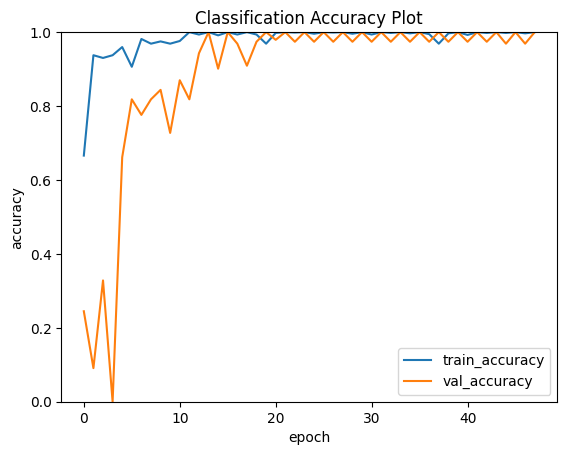

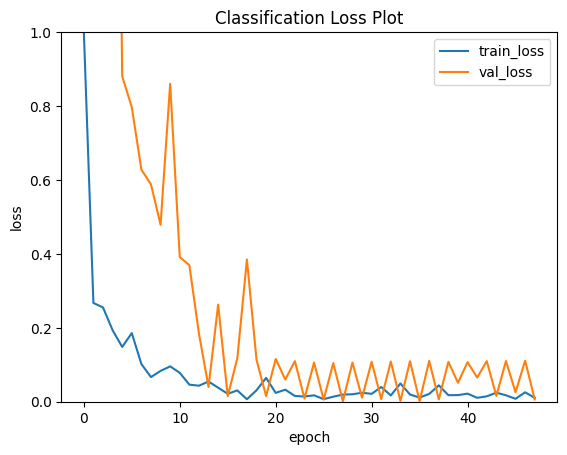

In [30]:
# Plot training and validation accuracy
plot_accuracy(history, 'Classification Accuracy Plot')

# Plot training and validation loss
plot_loss(history, 'Classification Loss Plot')


In [33]:

# Load the model weights from the specified file path
model.load_weights('/content/drive/MyDrive/fypmodel/MobilenetV1/new3/weights/MobileNet_weights-28.weights.h5')



In [34]:
# Make predictions on the test dataset using the trained model
predictions = model.predict(test_generator, verbose=0)

# Get the index of the highest probability class for each image
y_pred = np.argmax(predictions, axis=1)

# Get the true labels for the images from the test generator
y_true = test_generator.classes

# Retrieve the class names (labels) from the test generator
class_names = list(test_generator.class_indices.keys())

# Print the classification report which includes precision, recall, f1-score, and support
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:")
print(report)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.95      1.00      0.97        38
           2       1.00      0.92      0.96        38
           3       0.96      0.96      0.96        26
           4       0.97      1.00      0.99        38
           5       1.00      1.00      1.00        11
           6       0.97      1.00      0.99        38
           7       0.88      1.00      0.93         7

    accuracy                           0.97       207
   macro avg       0.97      0.96      0.96       207
weighted avg       0.97      0.97      0.97       207



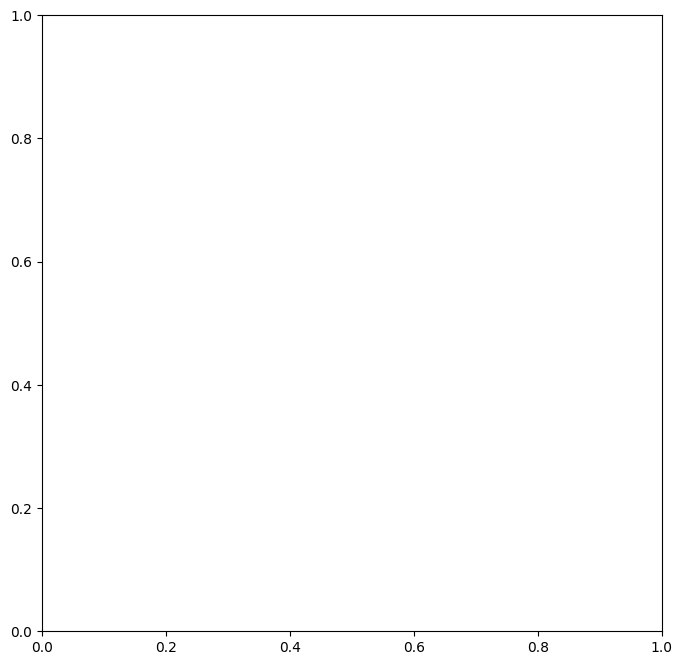

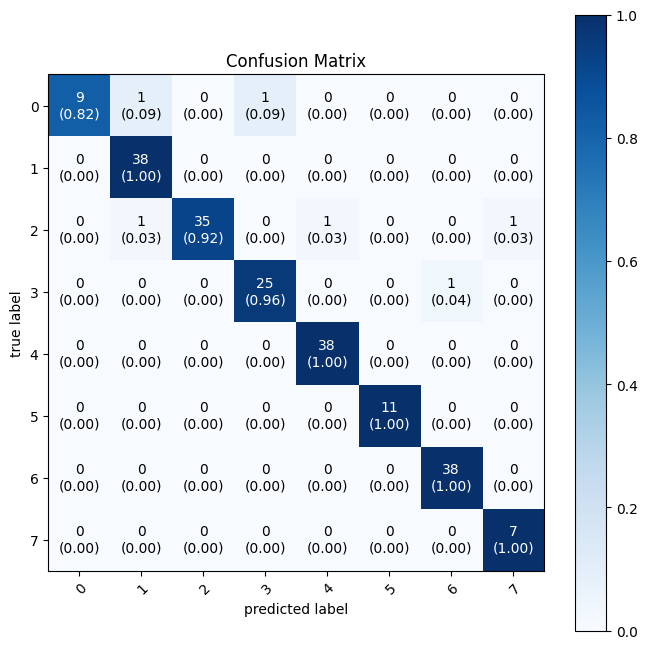

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(conf_mat=conf_matrix,
                      show_absolute=True,
                      show_normed=True,
                      colorbar=True,
                      class_names=class_names,
                      figsize=(8, 8),
                      cmap='Blues')

# Set the title and display the plot
plt.title('Confusion Matrix')
plt.show()


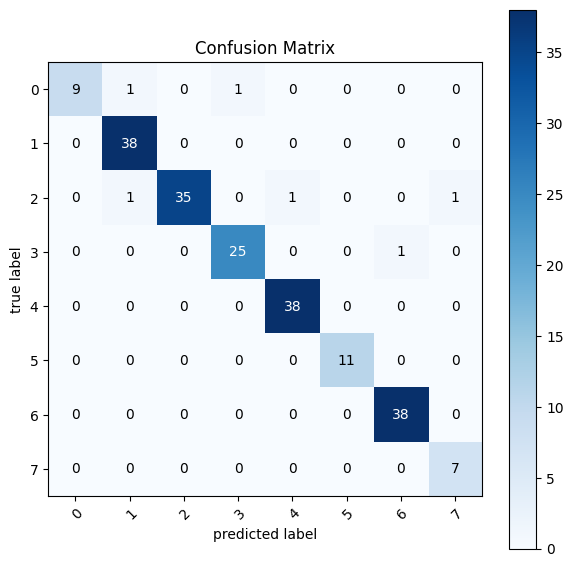

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix

# Compute the confusion matrix using sklearn's metrics module
cm = metrics.confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using mlxtend's `plot_confusion_matrix` function
fig, ax = plot_confusion_matrix( #  Remove the 'ax' argument from the function call
    conf_mat=cm,  # Pass the confusion matrix to the function
    show_absolute=True,  # Display the raw counts of predictions
    show_normed=False,  # Do not normalize the counts
    colorbar=True,  # Include a color bar to show the intensity of the values
    class_names=class_names,  # Provide the names of the classes for labeling
    figsize=(7, 7) # Specify the figure size here instead
)

# Set the title
plt.title('Confusion Matrix')

# Show the plot
plt.show()


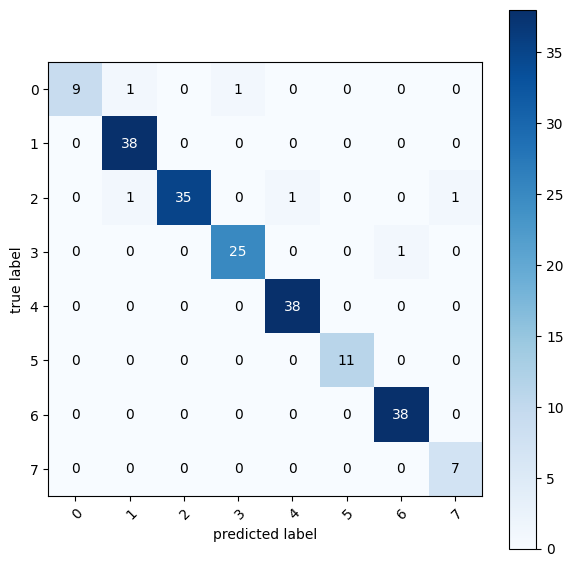

In [38]:
# Compute the confusion matrix using sklearn's metrics module
cm = metrics.confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using mlxtend's `plot_confusion_matrix` function
figure, ax = plot_confusion_matrix(
    conf_mat=cm,              # Pass the confusion matrix to the function
    show_absolute=True,       # Display raw counts in the confusion matrix
    show_normed=False,        # Do not display normalized values
    colorbar=True,            # Include a color bar to represent intensity of values
    class_names=class_names,  # List of class names for labeling axes
    figsize=(7, 7)            # Size of the plot (width, height)
)

# Display the confusion matrix plot
plt.show()


In [39]:
from sklearn.metrics import accuracy_score

# Compute the accuracy of the model
accuracy = accuracy_score(y_true, y_pred)

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9710


In [40]:
# Predict the classes of the test set
test_generator.reset()  # Reset the generator to ensure it starts from the beginning
predictions = model.predict(test_generator, steps=len(test_generator), verbose=0)  # Predict class probabilities
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

# True labels
true_classes = test_generator.classes  # Extract true class labels from the test generator

# Calculate accuracy
test_accuracy = accuracy_score(true_classes, predicted_classes)  # Compute accuracy score
print(f'Test Accuracy: {test_accuracy:.4f}')  # Print the accuracy score formatted to four decimal places


Test Accuracy: 0.9710


In [41]:
# Save the model in HDF5 format
model.save('/content/drive/MyDrive/fypmodel/output_models/lagacymodel.h5')
model.save('/content/drive/MyDrive/fypmodel/output_models/newmodel.keras')

In [42]:
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/fypmodel/output_models/newmodel.keras')

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('/content/drive/MyDrive/fypmodel/output_models/model.tflite', 'wb') as f:
    f.write(tflite_model)


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 85 variables whereas the saved optimizer has 168 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/tmp/tmpk95cnof0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(1, None, 8), dtype=tf.float32, name=None)
Captures:
  133421687564496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133424037425600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133424037428064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133421684754736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133421684752624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133424037414160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133424037426304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133424037417856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133424037424016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133424037422608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1334240374

In [43]:
import numpy as np

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/fypmodel/output_models/model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model with some data
test_image = np.random.random(size=(1, IMAGE_SIZE, IMAGE_SIZE, 3)).astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], test_image)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])
print(output)


[[[4.7343739e-04 7.2697895e-03 2.1830897e-03 5.7959454e-03 1.6426675e-04
   7.3100603e-01 6.9926590e-02 1.8318084e-01]]]
